# PLSQL Data Lineage tool

With this simple code, you can visualize your PLSQL code to help you understand the flow of data and dependencies in your project.

It's a simple code, but seems to be working just fine for me.

#### what you need:

libraries:
- graphviz (conda install -c anaconda graphviz)<br>
- pydot (conda install -c anaconda pydot)<br>
<br>
- your plsql code in 'plsql_code.txt' file in your root directory. <br>
- (optinal) List of tables used in PL/SQL 'tables.txt' - if you don't name the schema in your code explicitly <br>

Don't forget to first define the functions and lists in the code below.


In [62]:
from IPython.display import Image, display
import pydot
import os

In [63]:
f = open('plsql_code.txt') #open your plsql code
line = f.readline() # read the first line

In [64]:
G = pydot.Dot(graph_type="digraph")

In [65]:
child_tab = []

while line:
        # strip trailing spaces and newline
        line1 = line.rstrip()  
        line = line1.upper()
        list_tab = [] 
        
        # process the line
        
        #1.a get rid of commented code --
        if line.find('--') > 0:
            line = line[:line.find('--')]
        
        #1.b get rid of commented code /*
        
        if line.find('/*') > 0:
            line = line[:line.find('/*')]
            # process the code before /*
            list_tab = find_table(line)
            if type(list_tab) == list:
                
                if find_beggining(line) == 1:
                    if len(list_tab) > 0:                    
                        child_tab = list_tab[0]
                        if child_tab.find('DM') >= 0:
                            node = pydot.Node(child_tab, style="filled", fillcolor="green")
                        else:
                            node = pydot.Node(child_tab, style="filled", fillcolor="yellow")
                        G.add_node(node)
                else:
                    for i in list_tab:
                        if len(list_tab) > 0:                            
                            parent_tab = i
                            if parent_tab.find('DM') >= 0:
                                node = pydot.Node(parent_tab, style="filled", fillcolor="green")
                            else:
                                node = pydot.Node(parent_tab, style="filled", fillcolor="yellow")

                            G.add_node(node)
                            edge = pydot.Edge(parent_tab,child_tab)
                            G.add_edge(edge)


            while line.find('*/') < 0:
                line = f.readline() 
            # process the code after /*
            line1 = line[line.find('*/')+2:]   
            line = line1.upper()
        #2. handle the begining of the procedure or package
        
        line_upper = line.upper()
        if line_upper.find('CREATE OR REPLACE') >= 0:
            #print(line)
            line = f.readline() 
        
        # 3. process plsql code
        
        list_tab = find_table(line)
        if type(list_tab) == list:
            
            if find_beggining(line) == 1:
                if len(list_tab) > 0:    
                    child_tab = list_tab[0]
                    if child_tab.find('DM') >= 0:
                        node = pydot.Node(child_tab, style="filled", fillcolor="green")
                    else:
                        node = pydot.Node(child_tab, style="filled", fillcolor="yellow")
                    G.add_node(node)
            else:
                for i in list_tab:
                    if len(list_tab) > 0:                     
                        parent_tab = i
                        if parent_tab.find('DM') >= 0:
                            node = pydot.Node(parent_tab, style="filled", fillcolor="green")
                        else:
                            node = pydot.Node(parent_tab, style="filled", fillcolor="yellow")

                        G.add_node(node)
                        edge = pydot.Edge(parent_tab,child_tab)
                        G.add_edge(edge)
        # go to next line
        line = f.readline() 

In [66]:
f.close()

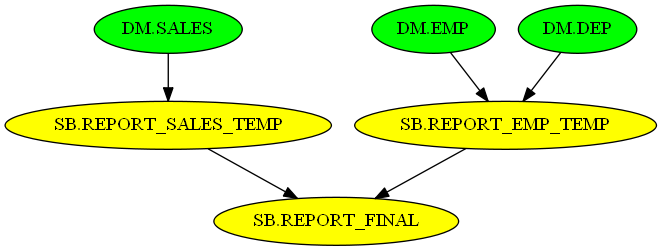

In [67]:
im = Image(G.create_png())
display(im)

list of schemas where to look for tables

In [25]:
schema = ['DM', 'SB'] 

import list of tables from db catalog to look or (optional)

In [4]:
tables = []
t = open('tables.txt')
line = t.readline()
while line:
    line = line.rstrip() 
    tables.append(line.upper())
    line = t.readline()
t.close()

Find table based on defined schema or list of tables

In [5]:
def find_table(text):
    list_tab = []
    for t in schema:
        pos_schema = text.find(t)
        #print(pos_schema)
        if pos_schema > 0:
            text_schema = text[pos_schema:]
            pos_sp = text_schema.find(' ')
            #print(pos_sp)
            if pos_sp > 0:
                tab = text_schema[:pos_sp]
            else:
                tab = text_schema
            #get rid of ')' at the end of a line
            if tab.find(')') > 0:
                #print(tab)
                tab = tab[:tab.find(')')]
            if tab.find('(') > 0:
                tab = tab[:tab.find('(')]
                #eliminate sequence
            if tab.find('NEXTVAL') < 0:
                list_tab.append(tab)

    if len(list_tab) > 0:
        return list_tab
   
    #look for provided tables
   
    for t in tables:
        if text.find(t) >= 0:
            # blank space or new line is required
            if text[text.find(t)+len(t):text.find(t)+len(t)+1] == ' ' or text[text.find(t)+len(t):text.find(t)+len(t)+1] == '':
                list_tab.append(t)
            #print(t)
    if len(list_tab) >= 0:
        return list_tab

detect the beggining of a command 

In [6]:
sql_start = ['INSERT INTO', 'CREATE TABLE', 'MERGE ', 'UPDATE ']

In [7]:
def find_beggining(text):
    for t in sql_start:
        pos_start = text.find(t)
        if pos_start >= 0:
            return 1
    return 0